<a href="https://colab.research.google.com/github/UMA314159/-morning4-Image-Classification/blob/main/%E3%83%99%E3%83%BC%E3%82%B9%E3%83%A9%E3%82%A4%E3%83%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#google ColabのDriveモジュールをインポートして、Googleドライブをマウントする許可を実行する。
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Zipfileを解凍
import zipfile

#with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/-morning4-SIGNATE-画像ラベリング/data/test_images.zip' , 'r') as zip_ref:
#    zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/-morning4-SIGNATE-画像ラベリング/data/test_images/')

In [3]:
#with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/-morning4-SIGNATE-画像ラベリング/data/train_images.zip' , 'r') as zip_ref:
#    zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/-morning4-SIGNATE-画像ラベリング/data/train_images/')

In [4]:
#データ処理ライブラリ
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score

# 画像処理ライブラリ
import cv2

#可視化ライブラリ
import matplotlib.pyplot as plt

#keras
import keras as ks
from keras.models import Sequential
from keras.layers import Dense , Dropout , Flatten , Conv2D , MaxPooling2D
from keras.utils import np_utils

#Pythonモジュール
import os
import glob

#表示設定
pd.options.display.max_rows = 78
pd.options.display.max_columns = 78

In [5]:
#label_dataの確認
label_master = pd.read_table('/content/drive/MyDrive/Colab Notebooks/-morning4-SIGNATE-画像ラベリング/data/label_master.tsv' , index_col=0)
label_master

,label_name
label_id,
0,airplane
1,bird
2,car
3,cat
4,deer
5,dog
6,horse
7,monkey
8,ship


In [6]:
#sampl_submitデータ
sample = pd.read_table('/content/drive/MyDrive/Colab Notebooks/-morning4-SIGNATE-画像ラベリング/data/sample_submit.tsv' , index_col = 0)
sample

,3
test_0.jpg,
test_1.jpg,8
test_2.jpg,3
test_3.jpg,3
test_4.jpg,2
test_5.jpg,6
...,...
test_7995.jpg,7
test_7996.jpg,5
test_7997.jpg,4


In [7]:
#train_labelデータの確認
train_label = pd.read_table('/content/drive/MyDrive/Colab Notebooks/-morning4-SIGNATE-画像ラベリング/data/train_master.tsv')
train_label

,file_name,label_id
0,train_0.jpg,1
1,train_1.jpg,5
2,train_2.jpg,1
3,train_3.jpg,6
4,train_4.jpg,3
...,...,...
4995,train_4995.jpg,1
4996,train_4996.jpg,5
4997,train_4997.jpg,1
4998,train_4998.jpg,7


In [8]:
test_path = '/content/drive/MyDrive/Colab Notebooks/-morning4-SIGNATE-画像ラベリング/data/test_images/test_images'
train_path = '/content/drive/MyDrive/Colab Notebooks/-morning4-SIGNATE-画像ラベリング/data/train_images/train_images'

In [9]:
train_label.file_name

0          train_0.jpg
1          train_1.jpg
2          train_2.jpg
3          train_3.jpg
4          train_4.jpg
             ...      
4995    train_4995.jpg
4996    train_4996.jpg
4997    train_4997.jpg
4998    train_4998.jpg
4999    train_4999.jpg
Name: file_name, Length: 5000, dtype: object

In [10]:
#ファイルのアクセス先と正解ラベルのdfを作成する
files_df = train_label.copy()

In [11]:
for i , file_name in enumerate(files_df.file_name):
    files_df.file_name[i] = train_path + '/' + file_name

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
files_df.file_name[0]

'/content/drive/MyDrive/Colab Notebooks/-morning4-SIGNATE-画像ラベリング/data/train_images/train_images/train_0.jpg'

In [13]:
#データサイズ確認
files_df.shape

(5000, 2)

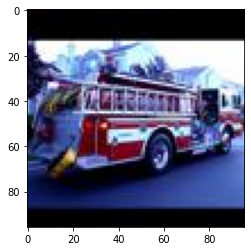

In [44]:
#画像の表示を確認
test_image = cv2.imread(files_df.file_name[5])
test_image = cv2.cvtColor(test_image , cv2.COLOR_BGR2RGB)
plt.imshow(test_image)
plt.show()

In [45]:
#3チャンネルの各色について確認
#チャンネル0
check_zero = test_image.copy()
check_zero[: , : , 1] = 0
check_zero[: , : , 2] = 0

#チャンネル1
check_one = test_image.copy()
check_one[: , : , 0] = 0
check_one[: , : , 2] = 0

#チャンネル2
check_two = test_image.copy()
check_two[: , : , 0] = 0
check_two[: , : , 1] = 0

Text(0.5, 1.0, '2')

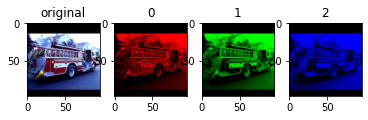

In [46]:
#画像を表示して確認する
fig, ax = plt.subplots(1, 4, figsize=(6,3))

# オリジナル
plt.subplot(141)
plt.imshow(test_image)
plt.title('original')

# 0チャンネル
plt.subplot(142)
plt.imshow(check_zero)
plt.title('0')

# 1チャンネル
plt.subplot(143)
plt.imshow(check_one)
plt.title('1')

# 2チャンネル
plt.subplot(144)
plt.imshow(check_two)
plt.title('2')

In [56]:
#x番目のレコードの画像ファイルを読み込み
def image_test(x):
    test_image = cv2.imread(files_df.file_name[x])
    test_image = cv2.cvtColor(test_image , cv2.COLOR_BGR2RGB)
    #読み込んだ画像データを表示
    plt.imshow(test_image)
    print('Labels-',files_df.label_id[x])
    print('Image Shape-',test_image.shape)
    plt.title('Image-Label' + str(label_master.iloc[files_df.iloc[x,1]]))
    plt.show()

Labels- 1
Image Shape- (96, 96, 3)


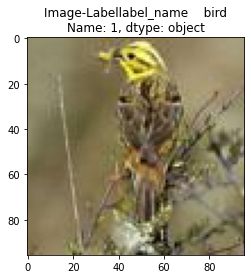

Labels- 2
Image Shape- (96, 96, 3)


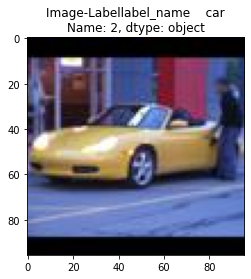

Labels- 0
Image Shape- (96, 96, 3)


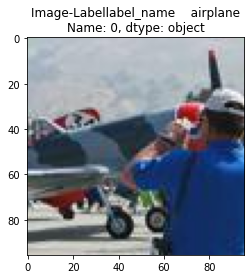

Labels- 6
Image Shape- (96, 96, 3)


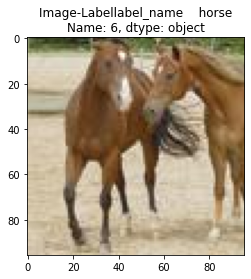

Labels- 3
Image Shape- (96, 96, 3)


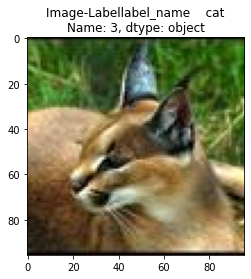

In [59]:
for i in range(0,5000,1000):
    image_test(i)

In [60]:
#各画像パス名のデータをシャッフル
files_df = files_df.sample(frac=1 , random_state=1).reset_index(drop=True)

In [63]:
test_image.size

27648

In [67]:
data_list = []

#画像データの読み込み
for i in range(len(files_df)):
    image = cv2.imread(files_df.file_name[i])
    image = image.reshape(test_image.size)
    data_list.append(image)
    if i % 1000 == 0:
        print(f'現在,{i}番目まで処理が完了しています。')

現在,0番目まで処理が完了しています。
現在,1000番目まで処理が完了しています。
現在,2000番目まで処理が完了しています。
現在,3000番目まで処理が完了しています。
現在,4000番目まで処理が完了しています。


In [69]:
data_list[0:10]

[array([207, 202, 201, ...,  97, 104, 107], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 1], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 3], dtype=uint8),
 array([0, 0, 3, ..., 0, 0, 0], dtype=uint8),
 array([147, 131,  89, ...,  49,  69,  87], dtype=uint8),
 array([ 83,  93, 100, ...,   0,   8,  16], dtype=uint8),
 array([190, 185, 187, ..., 254, 254, 254], dtype=uint8),
 array([ 54,  73,  70, ..., 142, 147, 150], dtype=uint8),
 array([151, 150, 140, ...,   0,   0,   0], dtype=uint8),
 array([ 33,  93, 135, ..., 127, 178, 210], dtype=uint8)]

In [70]:
#リストからNumpy配列へ変換
image_features = np.array(data_list)
image_features.shape

(5000, 27648)

In [71]:
#Numpy配列をnpyファイルとして書き出し
np.save('/content/drive/MyDrive/Colab Notebooks/-morning4-SIGNATE-画像ラベリング/data/image_features.npy' , image_features)

In [72]:
files_df.head()

,file_name,label_id
0,/content/drive/MyDrive/Colab Notebooks/-mornin...,2
1,/content/drive/MyDrive/Colab Notebooks/-mornin...,9
2,/content/drive/MyDrive/Colab Notebooks/-mornin...,8
3,/content/drive/MyDrive/Colab Notebooks/-mornin...,9
4,/content/drive/MyDrive/Colab Notebooks/-mornin...,1


In [73]:
#ターゲットデータの作成
y = files_df.label_id
y.value_counts()

2    500
9    500
8    500
1    500
3    500
4    500
7    500
6    500
5    500
0    500
Name: label_id, dtype: int64

In [74]:
y

0       2
1       9
2       8
3       9
4       1
       ..
4995    0
4996    6
4997    5
4998    5
4999    5
Name: label_id, Length: 5000, dtype: int64

Labels- 9
Image Shape- (96, 96, 3)


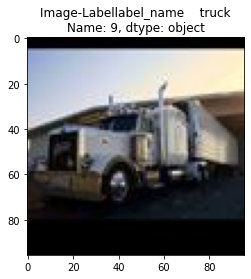

In [78]:
image_test(3)

In [80]:
#訓練データ/テストデータ分割
X_train , X_test , y_train , y_test = train_test_split(image_features,y,test_size=0.2 , random_state=1)
y_eval = y_test.copy()

#サイズを確認
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 27648)
(4000,)
(1000, 27648)
(1000,)


In [81]:
#データをfloat型へ変換
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#正規化
X_train /= 255
X_test /= 255

In [83]:
#kerasで訓練を行う用にデータを整形(バッチ、高さ、幅、チャンネル)
#size変更
X_train = X_train.reshape(X_train.shape[0] , 96 , 96 , 3)
X_test = X_test.reshape(X_test.shape[0] , 96 , 96 , 3)

In [84]:
print(X_train.shape)
print(X_test.shape)

(4000, 96, 96, 3)
(1000, 96, 96, 3)


In [85]:
y_train[0:5]

1233    1
1056    3
1686    5
187     5
3840    1
Name: label_id, dtype: int64

In [93]:
len(label_master)

10

In [90]:
len(y_train.unique())

10

In [94]:
#バイナリーのクラス行列へ変換
y_train = np_utils.to_categorical(y_train , len(label_master))
y_test = np_utils.to_categorical(y_test , len(label_master))

In [95]:
#クラス行列の変換ができているか確認
y_train[0:3]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [97]:
#ベースモデルとなるモデルの作成 VGG16を参考(0パディング追加)
#Sequentialモデルの生成
model1 = Sequential()

#1層目 96*96
#入力層兼畳み込み層を追加
model1.add(Conv2D(32,kernel_size=(3,3),
                  activation='relu',
                  padding='same'
                  input_shape = (96,96,3)))
#プール層を追加
model1.add(MaxPooling2D(pool_size=(2,2)))

#2層目 48*48
model1.add(Conv2D(64 , kernel_size=(3,3), activation='relu' , padding='same'))
model1.add(MaxPooling2D(pool_size= (2,2)))

#2層目 24*24
model1.add(Conv2D(128 , kernel_size=(3,3) , activation='relu' , padding='same'))
model1.add(MaxPooling2D(pool_size=(2,2)))

#3層目　12*12
model1.add(Conv2D(256 , kernel_size=(3,3) , activation='relu' , padding='same'))
model1.add(MaxPooling2D(pool_size=(2,2)))

#4層目　6*6
model1.add(Conv2D(512 , kernel_size=(3,3) , activation='relu' , padding='same'))
model1.add(MaxPooling2D(pool_size=(2,2)))

#全結合層1
model1.add(Flatten())
model1.add(Dense(4096,activation='relu'))
model1.add(Dense(4096,activation='relu'))
model1.add(Dense(1000,activation='relu'))

#出力層
model1.add(Dense(10,activation='softmax'))

SyntaxError: ignored